In [1]:
from main import *
from hyperparameter import *
from transferlearning import *

2024-09-27 10:58:05.644118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 10:58:05.673724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 10:58:05.695305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 10:58:05.700754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 10:58:05.712204: I tensorflow/core/platform/cpu_feature_guar

# Preprocessing

## Set the paths based on your Drive directory

In [2]:
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [3]:
train_images_dir

'data/Training'

## Preprocessing


### Don't touch this block

In [4]:
# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Data visualization

## Visualizing 15 random samples

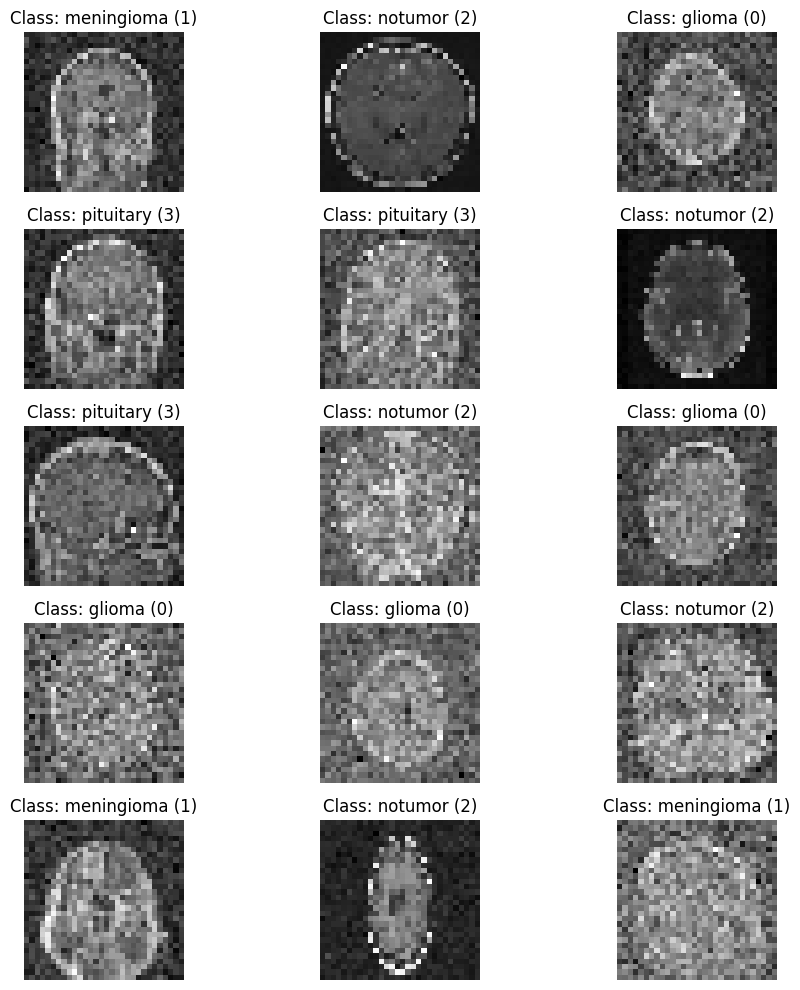

In [5]:
visualize_batch(train_data)

## Visualizing class distribution

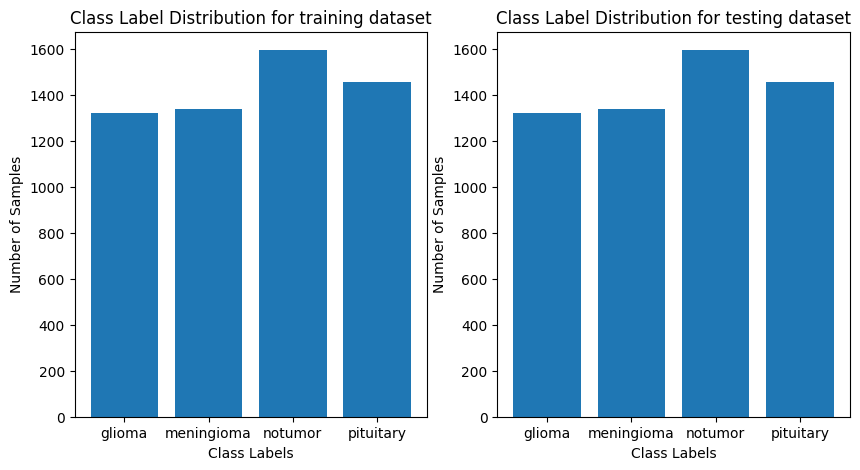

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
plot_class_dist(ax1, train_data, "training")
plot_class_dist(ax2, train_data, "testing")

# Training, validation, and test set

In [8]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35



I0000 00:00:1727427501.814002    1601 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727427502.024935    1601 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727427502.024999    1601 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727427502.028552    1601 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727427502.028732    1601 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


# Baseline Model

In [9]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())

In [10]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10


I0000 00:00:1727427507.422962    1700 service.cc:146] XLA service 0x7fc148004f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727427507.423039    1700 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-27 10:58:27.489790: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 10:58:27.723785: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 30/144 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - F1Score: 0.2131 - accuracy: 0.2908 - loss: 1.3555 - precision: 0.0238 - recall: 1.7361e-04    

I0000 00:00:1727427510.711982    1700 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - F1Score: 0.4018 - accuracy: 0.4391 - loss: 1.1891 - precision: 0.5982 - recall: 0.1500 - val_F1Score: 0.6619 - val_accuracy: 0.6703 - val_loss: 0.8592 - val_precision: 0.7539 - val_recall: 0.5634
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - F1Score: 0.7102 - accuracy: 0.7188 - loss: 0.7539 - precision: 0.7891 - recall: 0.6229 - val_F1Score: 0.7176 - val_accuracy: 0.7237 - val_loss: 0.7139 - val_precision: 0.7798 - val_recall: 0.6449
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - F1Score: 0.7595 - accuracy: 0.7686 - loss: 0.6336 - precision: 0.8137 - recall: 0.7043 - val_F1Score: 0.7317 - val_accuracy: 0.7400 - val_loss: 0.6576 - val_precision: 0.7977 - val_recall: 0.7002
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - F1Score: 0.7835 - accuracy: 0.7918 - loss: 0.5719 - precision: 0.8271 - recall: 0.7424 - val_F1Score: 0.7473 - val_accuracy: 0.7545 - val_loss: 0.6283 - val_precision: 0.7839 - val_recall: 0.7065
Epoch 5/10

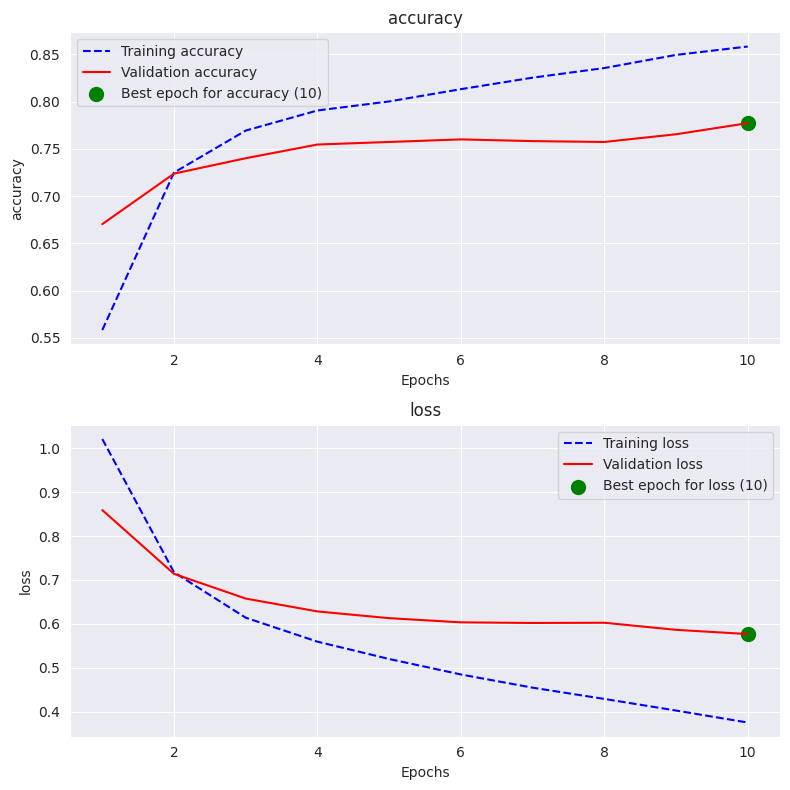

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


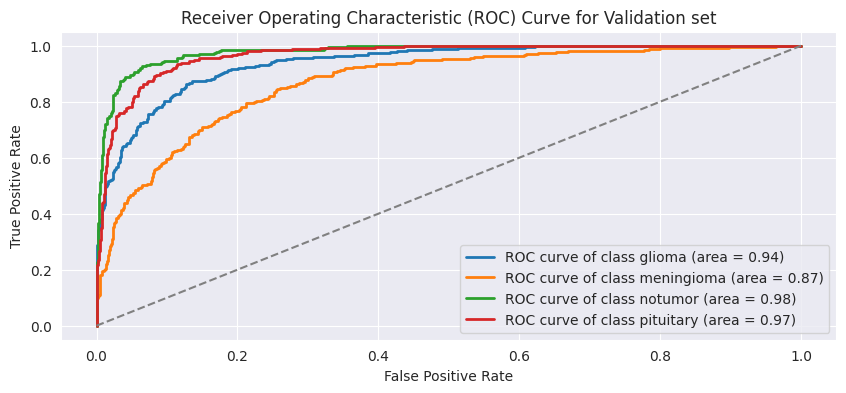

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


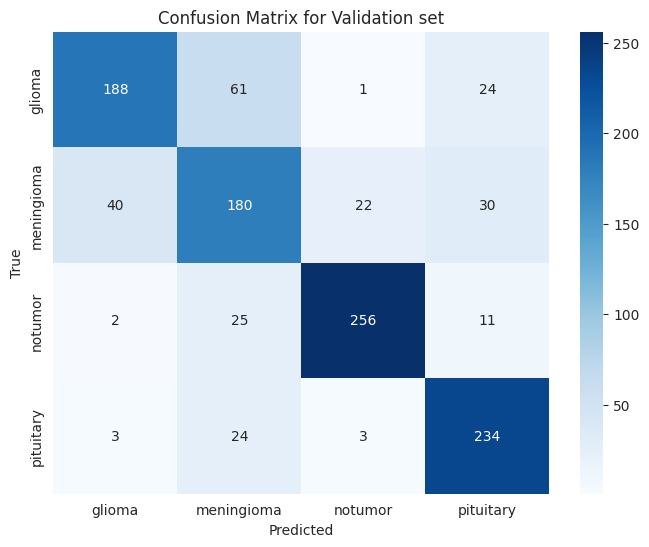

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


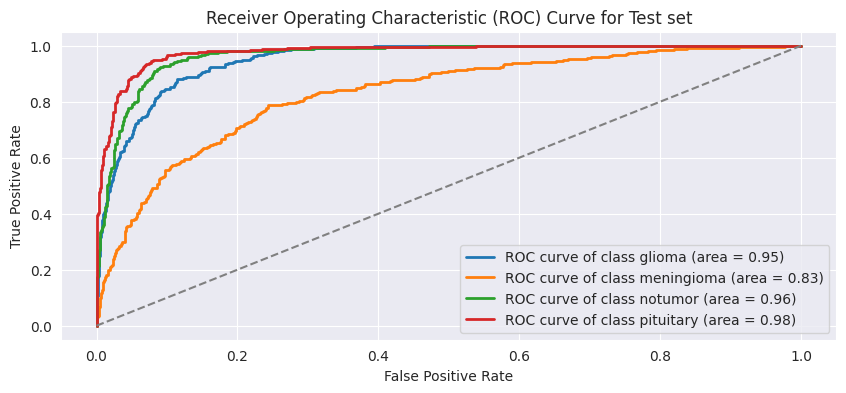

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


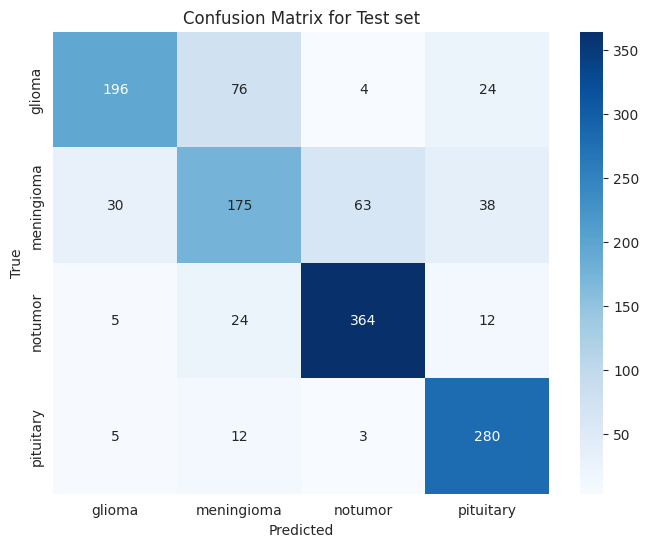

In [11]:
summarize_metric(history)

plot_roc_curve(base, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(base, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False, title = 'Test set')


In [12]:
models = [base]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Baselinemodel"}))
display(f1.rename(columns = {0: "F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - F1Score: 0.4570 - accuracy: 0.6903 - loss: 0.7388 - precision: 0.7085 - recall: 0.6531


,Baselinemodel
accuracy,0.774218
precision,0.792314
recall,0.739130


,F1
glioma,0.731343
meningioma,0.590219
notumor,0.867700
pituitary,0.856269


# Hyper parameter tuning
dense units, filters, kernels, max pooling, activation, LR are all tuneable

# Transfer learning

## VGG16

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


# vgg16 expects (224,224,3) input. Minimum input is (32,32,3) but it will not generate good features
vgg16_resolution = 224 

# initialize VGG16 model and make it non trainable. Don't get the last FC layer by setting include_top to false
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(vgg16_resolution,vgg16_resolution,3))
base_model.trainable = False 

# initialise model 
vgg16_model = Sequential()
# add vgg16 compliant input
vgg16_model.add(Input(shape = (vgg16_resolution, vgg16_resolution, 1)))

# change our image to 224x224
vgg16_model.add(layers.Lambda(lambda x: tf.image.resize(x, (vgg16_resolution, vgg16_resolution)))) 

# change image to rgb
vgg16_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))

# add vgg16 model 
vgg16_model.add(base_model)

# add as many FC layers as needed with dropout to prevent overfitting 
vgg16_model.add(layers.Flatten())
# vgg16_model.add(layers.Dense(128, activation='relu')) 
# Added L2 regularization and batch normalization
vgg16_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# vgg16_model.add(layers.BatchNormalization()) <-- does not seem to have positive impact
vgg16_model.add(layers.Dropout(0.3))
vgg16_model.add(layers.Dense(64, activation='relu')) # only one 64 unit layer results were: accuracy: 0.7567 - loss: 0.5959 - val_accuracy: 0.6993 - val_loss: 0.7358
# vgg16_model.add(layers.BatchNormalization()) <-- does not seem to have positive impact
vgg16_model.add(layers.Dense(4, activation='softmax'))

# compile model 
vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# add early stopping if accuracy does not change for 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

# fit the model 
vgg16_model.fit(X_train, y_train, epochs=1, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])


# We need to add code here for the ROC curve with AUC score, performance measures, and confusion matrix



2024-09-27 10:58:52.519810: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-27 10:58:52.766239: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 408.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-27 10:58:52.784182: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.40 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0} %get-tuple-element.26, f32[64,64,3,3]{3,2,1,0} %transpose.86, f32[64]{0} %arg5.6

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/tinus/tf/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/tinus/tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/tinus/tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/tinus/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/tinus/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/tinus/tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/tinus/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/tinus/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/tinus/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1601/2752734199.py", line 50, in <module>

  File "/home/tinus/tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/tinus/tf/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/tinus/tf/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.40 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0} %get-tuple-element.26, f32[64,64,3,3]{3,2,1,0} %transpose.86, f32[64]{0} %arg5.6), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv2_1/convolution" source_file="/home/tinus/tf/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 427819008 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_28356]

## Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Replace vgg16 with resnet50

resnet_resolution = 224 
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(resnet_resolution,resnet_resolution,3))
base_model.trainable = False ## 

resnet_model = Sequential()
resnet_model.add(Input(shape = (resnet_resolution, resnet_resolution, 1)))
resnet_model.add(layers.Lambda(lambda x: tf.image.resize(x, (resnet_resolution, resnet_resolution)))) 
resnet_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
resnet_model.add(base_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dropout(0.3))
resnet_model.add(layers.Dense(64, activation='relu'))
resnet_model.add(layers.Dense(4, activation='softmax'))


resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

resnet_model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])


## Densenet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

# Replace vgg16 with densenet


densenet_resolution = 224
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(densenet_resolution,densenet_resolution,3))
base_model.trainable = False ## 

densenet_model = Sequential()
densenet_model.add(Input(shape = (resnet_resolution, resnet_resolution, 1)))
densenet_model.add(layers.Lambda(lambda x: tf.image.resize(x, (densenet_resolution, densenet_resolution)))) 
densenet_model.add(layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)))
densenet_model.add(base_model)
densenet_model.add(layers.Flatten())
densenet_model.add(layers.Dense(128, activation='relu'))
densenet_model.add(layers.Dense(4, activation='softmax'))


densenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

densenet_model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), batch_size=32, callbacks=[early_stopping])
